# Overview

This notebook serves as a demonstration of what the toolbox can do. This project is a work in progress, so there will be updates to the code and subsequently the applications. Below are some highlights of what is currently possible.

# Datasets

The starting point of the project is the ability to easily load chemical datasets into a format that is usable from a Machine Learning perspective. All the relevant datasets make use of **SMILES** (Simplified molecular-input line-entry system) to store information on molecules. The in-built ``DataSet`` objects then take the SMILES representation of molecules together with a target array and any other additional information, and load then into **graphs**.

Below is an example of an implemented dataset that can, similarly to the torch datasets, download and load a dataset from the internet.

## Jean-Claude Bradley Open Melting Point Dataset [1]

In [122]:
from grape.datasets import BradleyDoublePlus
print(f'length of dataset at the start: {3024}\n-------------')
data = BradleyDoublePlus(log=True, only_organic=True)
print(f'-------------\nlength of dataset at the end: {len(data)}')

length of dataset at the start: 3024
-------------
SMILES [O-][N+]#N in index 1 does not contain at least one carbon and will be ignored.
SMILES FS(F)(=O)=O in index 2 does not contain at least one carbon and will be ignored.
SMILES BrBr in index 4 does not contain at least one carbon and will be ignored.
SMILES II in index 8 does not contain at least one carbon and will be ignored.
SMILES ClS(Cl)(=O)=O in index 79 does not contain at least one carbon and will be ignored.
SMILES B(OCC)(OCC)OCC in index 144 contains the atom B that is not permitted and will be ignored.
SMILES c1cccn1 in index 308 is not valid.
SMILES N#Cc3cncc3c1cccc2OC(F)(F)Oc12 in index 370 is not valid.
SMILES CC[Si](CC)(CC)CC in index 519 contains the atom Si that is not permitted and will be ignored.
SMILES CC[Si](CC)(Cl)Cl in index 541 contains the atom Si that is not permitted and will be ignored.
SMILES [SiH](Cl)(Cl)Cl in index 565 contains the atom Si that is not permitted and will be ignored.
SMILES [SiH](Cl)(

As seen above, the data loader filters the SMILES based a few different criteria. One of them is a check if rdkit recognizes the SMILES representation as valid, another one is whether the SMILES atoms are **all** part of the *allowed* atom symbols. After filtering, we can access the information using the regular class notations.

### Example outputs

We can access the SMILES from the melting point dataset as such:

In [123]:
# SMILES
data.smiles[0:5]

array(['CC1CCC1', 'CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C',
       'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21', 'CN(C)C',
       'ClC(Cl)(Cl)Cl'], dtype=object)

And their corresponding graphs are stored at the same indices.

In [124]:
# Their corresponding graphs, saved using the torch geometric Data objects.
data[0:5]

[Data(x=[5, 44], edge_index=[2, 10], edge_attr=[10, 12], y=[1]),
 Data(x=[25, 44], edge_index=[2, 52], edge_attr=[52, 12], y=[1]),
 Data(x=[25, 44], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[4, 44], edge_index=[2, 6], edge_attr=[6, 12], y=[1]),
 Data(x=[5, 44], edge_index=[2, 8], edge_attr=[8, 12], y=[1])]

We can draw any of the loaded SMILES using rdkit directly:

SMILES: C=C(C)OC(C)=O
Target:  -93.0  [Celsius]
Graph Target:  tensor([-93.])  [Celsius]


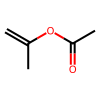

In [125]:
print('SMILES:', data.smiles[10])
print('Target: ', data.target[10], ' [Celsius]')
print('Graph Target: ', data.graphs[10].y, ' [Celsius]')
data.draw_smile(10)


SMILES: CCCCCCCCCCCCCCCCCCBr
Target:  28.0  [Celsius]
Graph Target:  tensor([28.])  [Celsius]


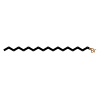

In [126]:
print('SMILES:', data.smiles[100])
print('Target: ', data.target[100], ' [Celsius]')
print('Graph Target: ', data.graphs[100].y, ' [Celsius]')
data.draw_smile(100)

SMILES: O=C1Cc2ccccc2C(=O)O1
Target:  142.0  [Celsius]
Graph Target:  tensor([142.])  [Celsius]


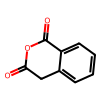

In [127]:
print('SMILES:', data.smiles[1000])
print('Target: ', data.target[1000], ' [Celsius]')
print('Graph Target: ', data.graphs[1000].y, ' [Celsius]')
data.draw_smile(1000)

We can also save and load the dataset as such:

In [128]:
# We can also save and load the dataset as such:
# Dataset are saved using pickle, which allows for fast saving and loading. Saving a dataset and then loading instead of loading from, for example, an excel file is about 10 to 20 times faster.

from grape.utils import DataSet

data.save_dataset('BradleyDoublePlus')
loaded_dataset = DataSet(file_path='./data/processed/BradleyDoublePlus.pickle')
loaded_dataset.smiles[0:5]

File saved at: ./data/processed/BradleyDoublePlus.pickle
Loaded dataset.


array(['CC1CCC1', 'CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C',
       'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21', 'CN(C)C',
       'ClC(Cl)(Cl)Cl'], dtype=object)

Datasets are saved using pickle, which allows for fast saving and loading. Saving a dataset and then loading from the pickle directly instead of regenerating it from the orignal data is about 10 to 20 times faster.

# Analysis

There are several options to analyze a loaded dataset. Below are some of these options.

## Naive clustering
This chart is generated using a simple clustering algorithm that checks the letter in the SMILES and puts them into the below seen molecule classes. For example, if a SMILES only contains an 'O' and no other class letter, then it is part of 'Oxygenated'. If it contains 'O' and 'Cl', then it is part of 'Multifunctional'.

<Axes: xlabel='compound class', ylabel='number of molecules'>

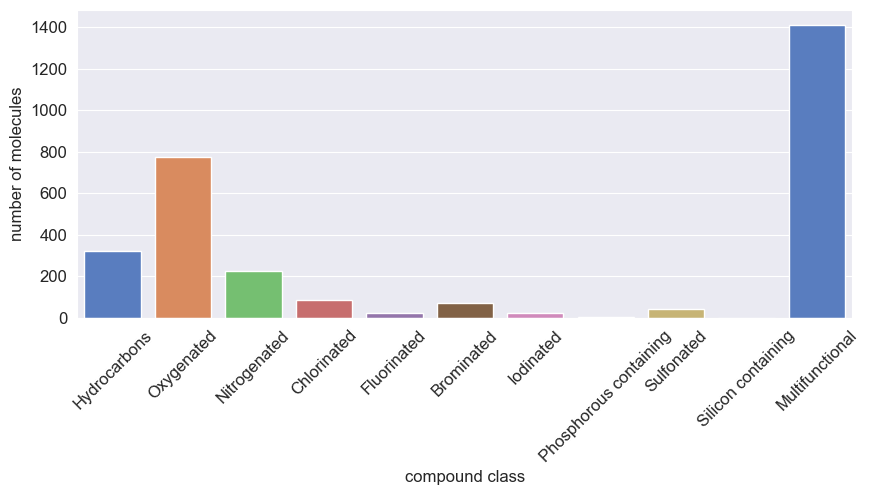

In [129]:
from grape.plots import compound_nums_chart

compound_nums_chart(data.smiles, fig_size=(10,4))

## Classyfire
An almost always more useful clustering is using the Classyfire [2] classification done by Feunang et al.. In code terms, we pull the online documentation of the molecules in question with their Classyfire information, read it and cluster them based on that. This approach is far superior over the simple one above, but can take very long to do (it takes about 2 min to retrieve the information for 100 molecules).

In [130]:
subset_smiles = data.smiles[100:200]

from grape.analysis import classyfire, classyfire_result_analysis
ids, data_ids = classyfire(subset_smiles, log=False)
smile_classes, class_num_dictionary = classyfire_result_analysis(idx=ids)
print(class_num_dictionary)

Found log file in working directory.
All passed smiles are already in the passed log_file.
Key error occurred using superclass for file 683.json.
Key error occurred using superclass for file 695.json.
Key error occurred using superclass for file 656.json.
Key error occurred using superclass for file 640.json.
Key error occurred using superclass for file 660.json.
Key error occurred using superclass for file 621.json.
Key error occurred using superclass for file 699.json.
Key error occurred using superclass for file 676.json.
{'Benzenoids': 37, 'Phenylpropanoids and polyketides': 1, 'Organic nitrogen compounds': 3, 'Organophosphorus compounds': 1, 'Organoheterocyclic compounds': 11, 'Organic oxygen compounds': 5, 'Organohalogen compounds': 13, 'Hydrocarbons': 9, 'Organic acids and derivatives': 7, 'Acetylides': 1, 'Lipids and lipid-like molecules': 2, 'Alkaloids and derivatives': 1, 'Organosulfur compounds': 1}


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='compound class', ylabel='number of molecules'>)

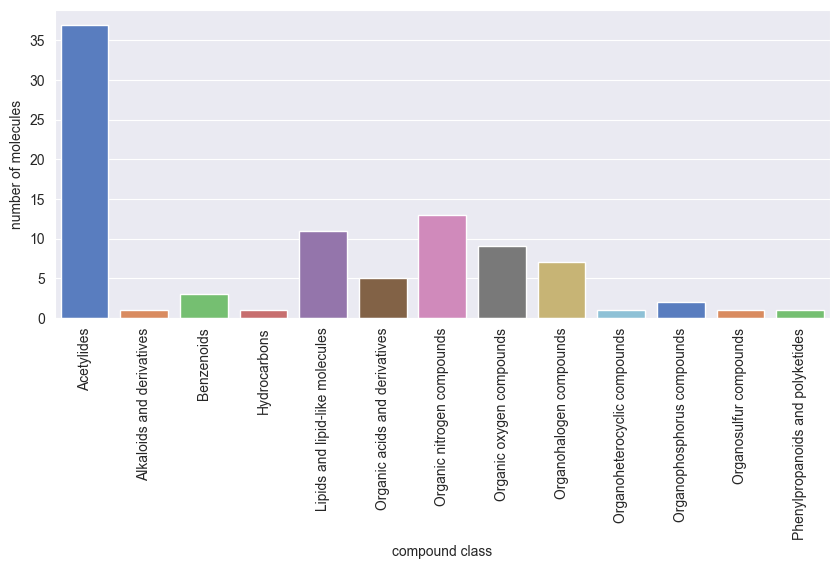

In [131]:
from grape.plots import num_chart
num_chart(class_num_dictionary, fig_size=(10,4))

The classyfire code is split in two: (1) ``classyfire`` sends the relevant information to the classyfire website (http://classyfire.wishartlab.com/) and retrieves the class information as a json file. Furthermore, a csv file called ``recorded_SMILES`` is generated that stores the json file indices together with corresponding SMILES to prevent double downloading. (2) ``classyfire_result_analysis`` reads the json files and return dictionaries with all SMILES and their class as well as class frequency dictionary. That dictionary can then be fed directly to a class frequency plotting function.

## Molecular Weight against Target
Another option for visual analysis is to plot the molecule weight against the target attribute. This might give an indication on how molecule size correlates with the target, often a usual observation.

[-161.51   94.8   239.75 ...  176.     65.    -34.  ]


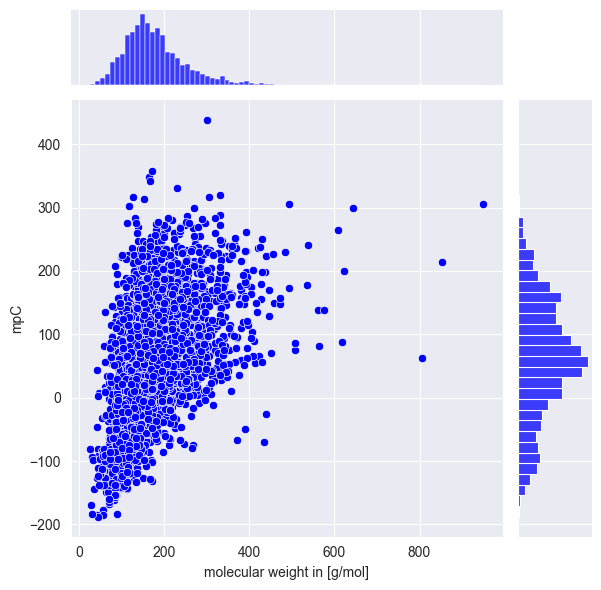

In [132]:
from grape.plots import mol_weight_vs_target
print(data.target)
mol_weight_vs_target(data.smiles, data.target, save_fig=True, fig_height=6, target_name='mpC')

## Feature number charts
If only a basic analysis of the dataset, is needed, then one can generate number charts based on the featurizion of the molecules. The implementation is built on top of DGL-LIFESCI ```analyze_mols``` function ([github](https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/utils/analysis.py)), below is an example.

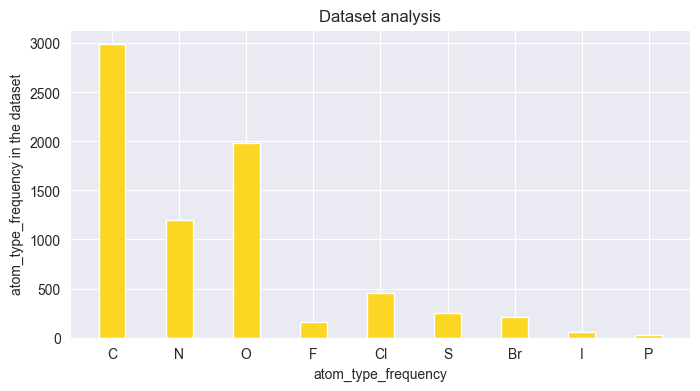

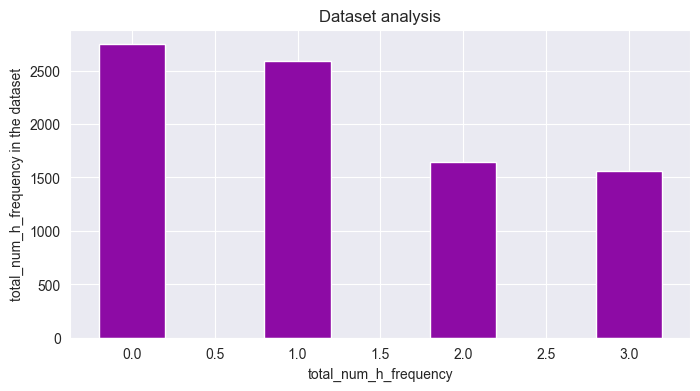

In [133]:
%matplotlib inline

results, figures = data.analysis(download=True, plots=['atom_type_frequency','total_num_h_frequency'], fig_size=[8,4],
                                 save_plots=True)

We could also plot the number of heavy atoms as a barchart:

<Axes: title={'center': 'Heavy atoms distribution'}, xlabel='Number of heavy atoms per molecule', ylabel='Counts'>

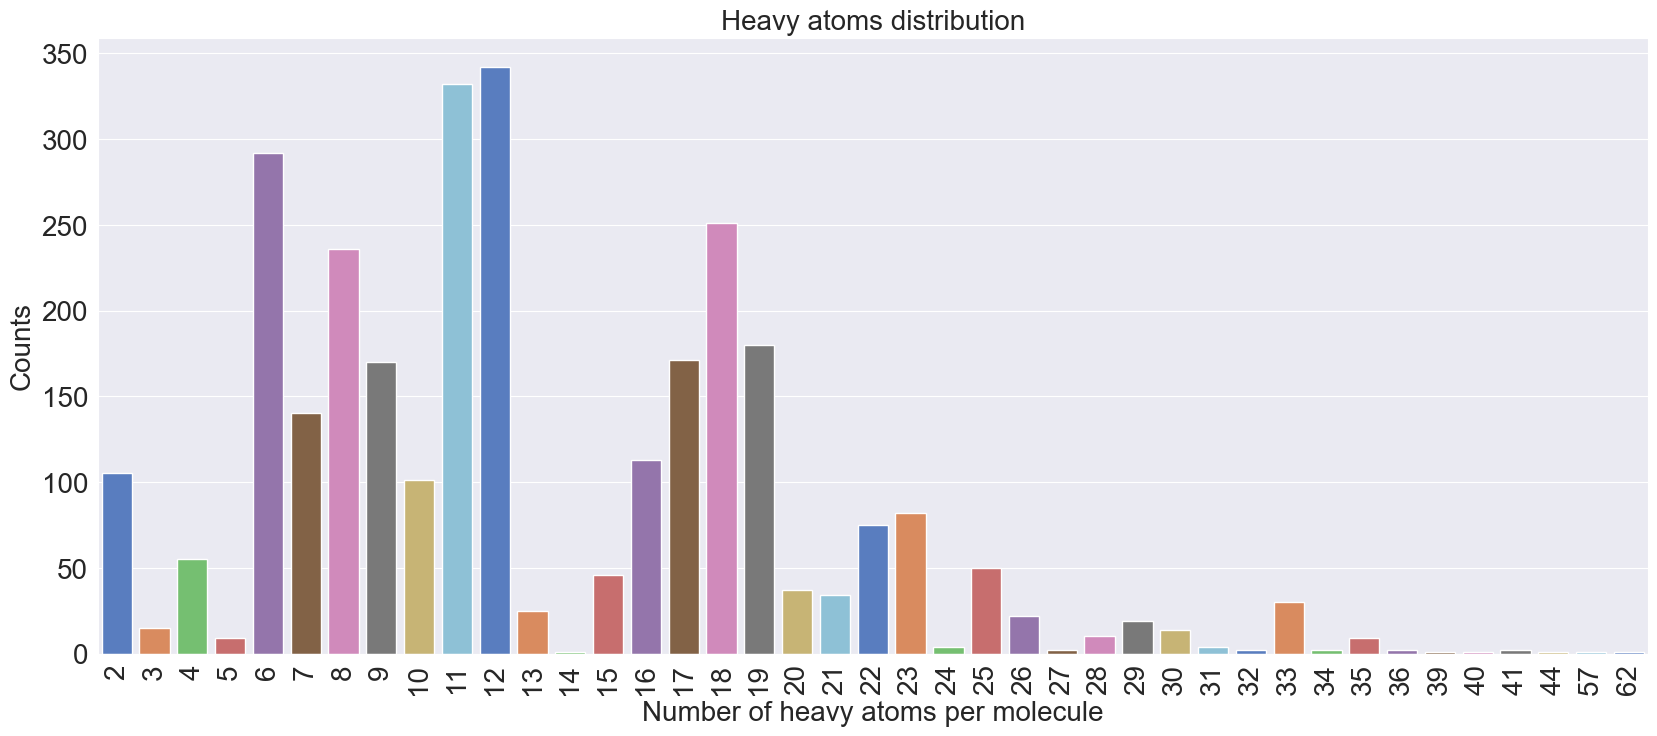

In [134]:
from grape.plots import num_heavy_plot
num_heavy_plot(data.smiles, fig_size=(20,8))

# Clustering and data splitting
There are several ways to split the graph dataset into the training, validation and testing splits, including random, stratified or by molecular weight. A more interesting addition in this toolbox is a split based on **Butina clustering** [2], where the molecules are clustered based on the Morgan Fingerprint and the Tanimoto similarity. Within there are two options: (1) a **uniform** split where we sample across all clusters evenly, and (2) a **realistic** split where we fill up the train., val. and test. split with clusters from largest to smallest in order.

Below, we choose the *realistic* split:


In [135]:
from grape.datasets import BradleyDoublePlus
data = BradleyDoublePlus()

train, val, test = data.split_and_scale(scale=True, split_type='butina_realistic', seed=42, is_dmpnn=True);

100%|██████████| 295/295 [00:00<00:00, 2392.48it/s]


Note that we scale using the training set immediately and that we specify that we are working with DMPNN (a directional GNN).

# GNN Model
With the data loaded, filtered, featurizerized and split, let's define a Graph Neural Network and test it! We can always find the number of features like thus:

In [136]:
print(f'Node feature dimension: {data.num_node_features}')
print(f'Edge feature dimension: {data.num_edge_features}')

Node feature dimension: 44
Edge feature dimension: 12


## Model definition
To define a model, all we need to do is load one of the in-built models like ``MPNN`` or ``MEGNet`` and apply it. Any model that can handle the PyG graphs as input would work for that matter, fx. one could use the PyG models instead. Below, we load the ``DMPNN`` model directly from the package and initialize it:

In [137]:
from grape.models import DMPNN
import torch

node_hidden_dim = 64 
batch_size = 32
mlp_layers = [512, 256, 128]


model = DMPNN(node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features, node_hidden_dim=node_hidden_dim,
              mlp_out_hidden=mlp_layers)

                  

print('Full model:\n--------------------------------------------------')
print(model)

device = torch.device('cpu')

Full model:
--------------------------------------------------
DMPNN(
  (rep_dropout): Dropout(p=0.0, inplace=False)
  (encoder): DMPNNEncoder(
    (act_func): ReLU()
    (W1): Linear(in_features=56, out_features=64, bias=True)
    (W2): Linear(in_features=64, out_features=64, bias=True)
    (W3): Linear(in_features=108, out_features=64, bias=True)
    (dropout_layer): Dropout(p=0.15, inplace=False)
  )
  (mlp_out): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


## Loss and Optimizer
Like with any deep learning model, we define a loss function and optimizer.

In [138]:
from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

We can additionally define an Early Stopper to help improve the output:

In [139]:
from grape.utils import EarlyStopping
early_stopper = EarlyStopping(patience=30, model_name='best_model')

As well as a scheduler to reduce the learning-rate whenever the training hits a plateau:

In [140]:
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, min_lr=0.0000000000001, patience=15)

## Training
Here, we just use the previous determined training and validation splits to train the model inside the ```train_model``` function:

In [141]:
from grape.utils import train_model

train_loss, val_loss = train_model(model = model,
                                  loss_func = 'mse',
                                  optimizer = optimizer,
                                  train_data_loader= train,
                                  val_data_loader = val,
                                  batch_size=batch_size,
                                  epochs=300,
                                  early_stopper=early_stopper,
                                   scheduler=scheduler)

model.load_state_dict(torch.load('best_model.pt'))

epoch=58, training loss= 0.085, validation loss= 0.435:  20%|█▉        | 59/300 [00:20<01:25,  2.81it/s]

Early stopping reached with best validation loss 0.3475
Model saved at: best_model.pt


<All keys matched successfully>

## Loss plot

The training function returns the training and validation losses which can visualize as:

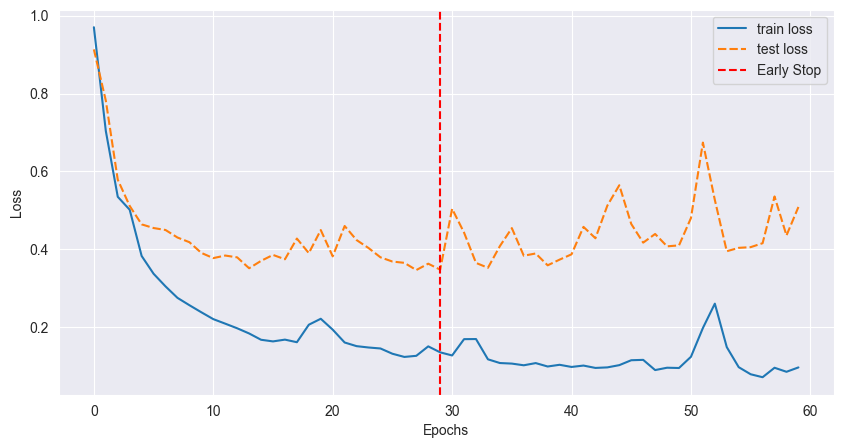

In [142]:
from grape.plots import loss_plot
loss_plot([train_loss, val_loss], ['train loss', 'test loss'], early_stopper.stop_epoch)

# Testing and Post-processing

For testing, we use the ``test_model`` from the toolbox which essentially just uses predicts the test SMILES using the trained model:

In [143]:
from grape.utils import test_model
preds = test_model(model=model,
                   test_data_loader=test)

100%|██████████| 10/10 [00:00<00:00, 321.96it/s]


Then we calculate some (re-scaled) metrics on the predictions using ``pred_metric``:

In [144]:
from grape.utils import pred_metric
pred_metric(prediction=preds,target=test.y, metrics='all', print_out=True, rescale_data=data);

MSE: 3983.246
RMSE: 63.113
SSE: 1175057.582
MAE: 48.646
R2: 0.610
MRE: 68.287%
MDAPE: 27.807%


Note that we have to pass the original data object to make sure we are recaling on the correct data.

## Parity and Residual plots

We could also choose to plot the parity and residual plots:

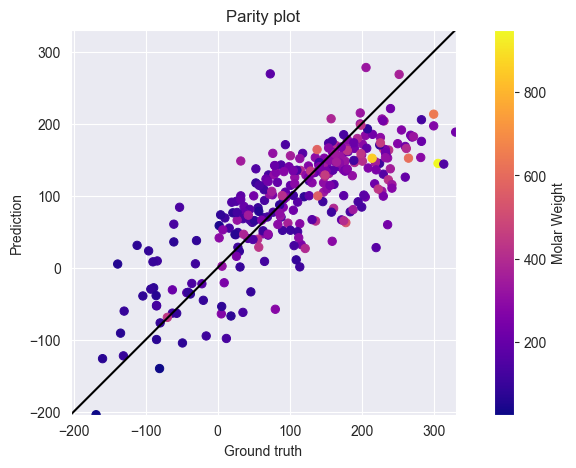

In [145]:
from grape.plots import parity_plot, residual_plot
# We rescale the predictions and ground truth before plotting
preds_rescaled, test_y_rescaled = data.rescale_data(preds), data.rescale_data(test.y)
parity_plot(prediction=preds_rescaled,target=test_y_rescaled, mol_weights=test.mol_weights);

<Axes: title={'center': 'Residual plot'}, xlabel='Ground truth', ylabel='Residual'>

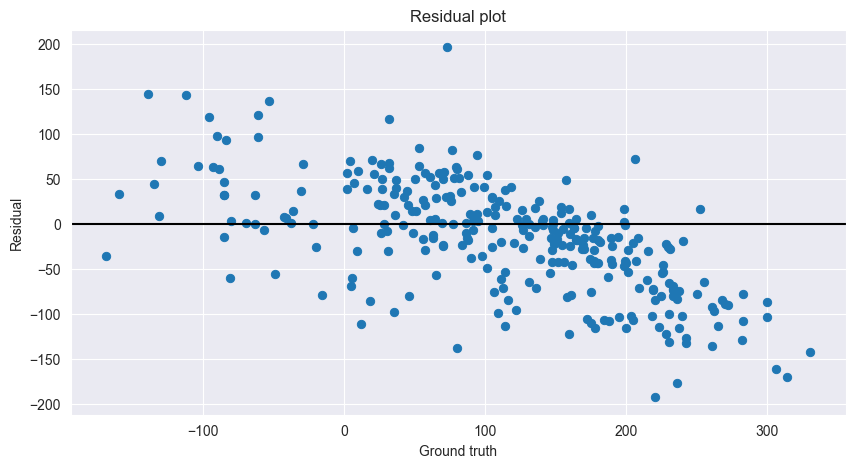

In [146]:
residual_plot(prediction=preds_rescaled,target=test_y_rescaled)

## Metrics

We can also examine the how the over splits, training and validation, behave. To do so, we might calculate average or **overall** metrics:

In [147]:
# Generating the predictions

train_preds = test_model(model=model,test_data_loader=train)
val_preds = test_model(model=model,test_data_loader=val)
test_preds = test_model(model=model,test_data_loader=test)

100%|██████████| 10/10 [00:00<00:00, 403.26it/s]


In [148]:
# Overall R2

overall = 0
overall += pred_metric(prediction=train_preds,target=train.y, metrics='r2', print_out=False)['r2']
overall += pred_metric(prediction=val_preds,target=val.y, metrics='r2', print_out=False)['r2']
overall += pred_metric(prediction=test_preds,target=test.y, metrics='r2', print_out=False)['r2']
print(f'Overall R2: {overall/3}')

Overall R2: 0.7259719639871623


In [149]:
# Overall MAE

overall = 0
overall += pred_metric(prediction=train_preds,target=train.y, metrics='mae', print_out=False, rescale_data=data)['mae']
overall += pred_metric(prediction=val_preds,target=val.y, metrics='mae', print_out=False, rescale_data=data)['mae']
overall += pred_metric(prediction=test_preds,target=test.y, metrics='mae', print_out=False, rescale_data=data)['mae']
print(f'Overall MAE: {overall/3}')

Overall MAE: 39.97985859806776


## Residual Density

Furthermore, using the predictions from all three splits we can plot the residual density:

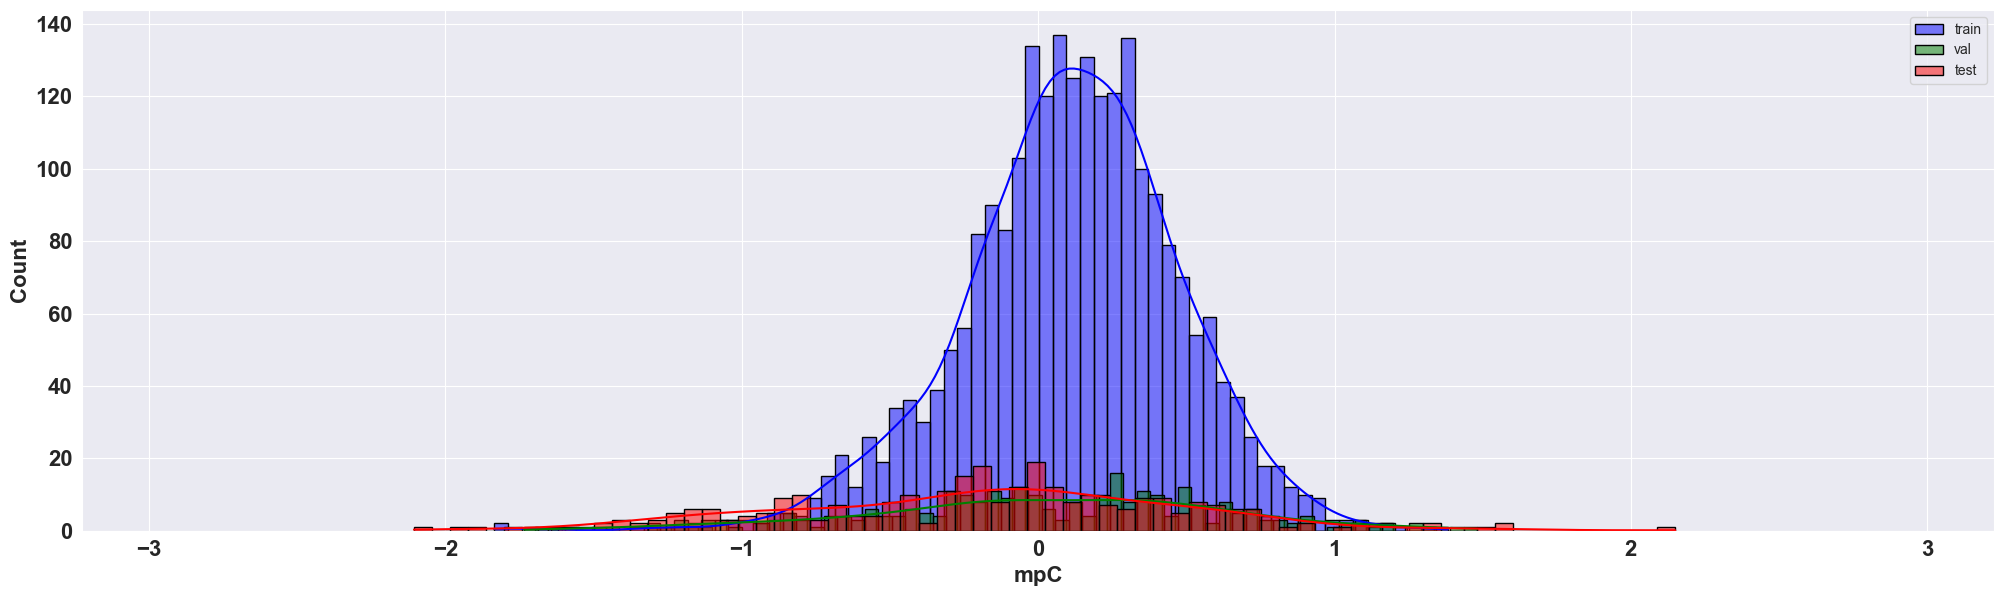

In [150]:
from grape.plots import residual_density_plot
residual_density_plot(train_pred=train_preds, val_pred=val_preds, test_pred=test_preds,
                      train_target=train.y, val_target=val.y, test_target=test.y)

For the (scaled) residual density plot, we are looking to examine how our errors or residuals behave. Namely, we want them to be normally distributed, and they seem to be!

## Latent analysis

### PCA

Finally, we could analyze the model latents by applying a PCA model and plotting them based on groups. Let us first classify a subset of our test SMILES and label them according to their classes:

In [151]:
from grape.analysis import classyfire, classyfire_result_analysis
ids, data_ids = classyfire(test.smiles[:100], log=False)
# -> ids are used for the result analysis and data_ids for specifying the data point from the test set we can use

class_dict, smile_dict, rel_ids = classyfire_result_analysis(idx=ids, layer=1, return_relative_ids=True)

Found log file in working directory.
All passed smiles are already in the passed log_file.
Key error occurred using superclass for file 683.json.
Key error occurred using superclass for file 695.json.
Key error occurred using superclass for file 656.json.
Key error occurred using superclass for file 640.json.
Key error occurred using superclass for file 660.json.
Key error occurred using superclass for file 621.json.
Key error occurred using superclass for file 699.json.
Key error occurred using superclass for file 676.json.


In [152]:
indices = list(class_dict.keys())
labels = list(class_dict.values())
print(labels[:10])

['Benzenoids', 'Benzenoids', 'Benzenoids', 'Benzenoids', 'Phenylpropanoids and polyketides', 'Benzenoids', 'Organic nitrogen compounds', 'Organophosphorus compounds', 'Organoheterocyclic compounds', 'Organoheterocyclic compounds']


This will let us label the PCA plot much better. Now we can retrieve and generate the PCA plot:

In [153]:
lats_data = test[:100]
preds, lats = test_model(model, test_data_loader=lats_data, return_latents=True)
lats = lats.cpu().detach().numpy()

100%|██████████| 4/4 [00:00<00:00, 303.30it/s]


<Axes: title={'center': "PCA using the two first PC's"}>

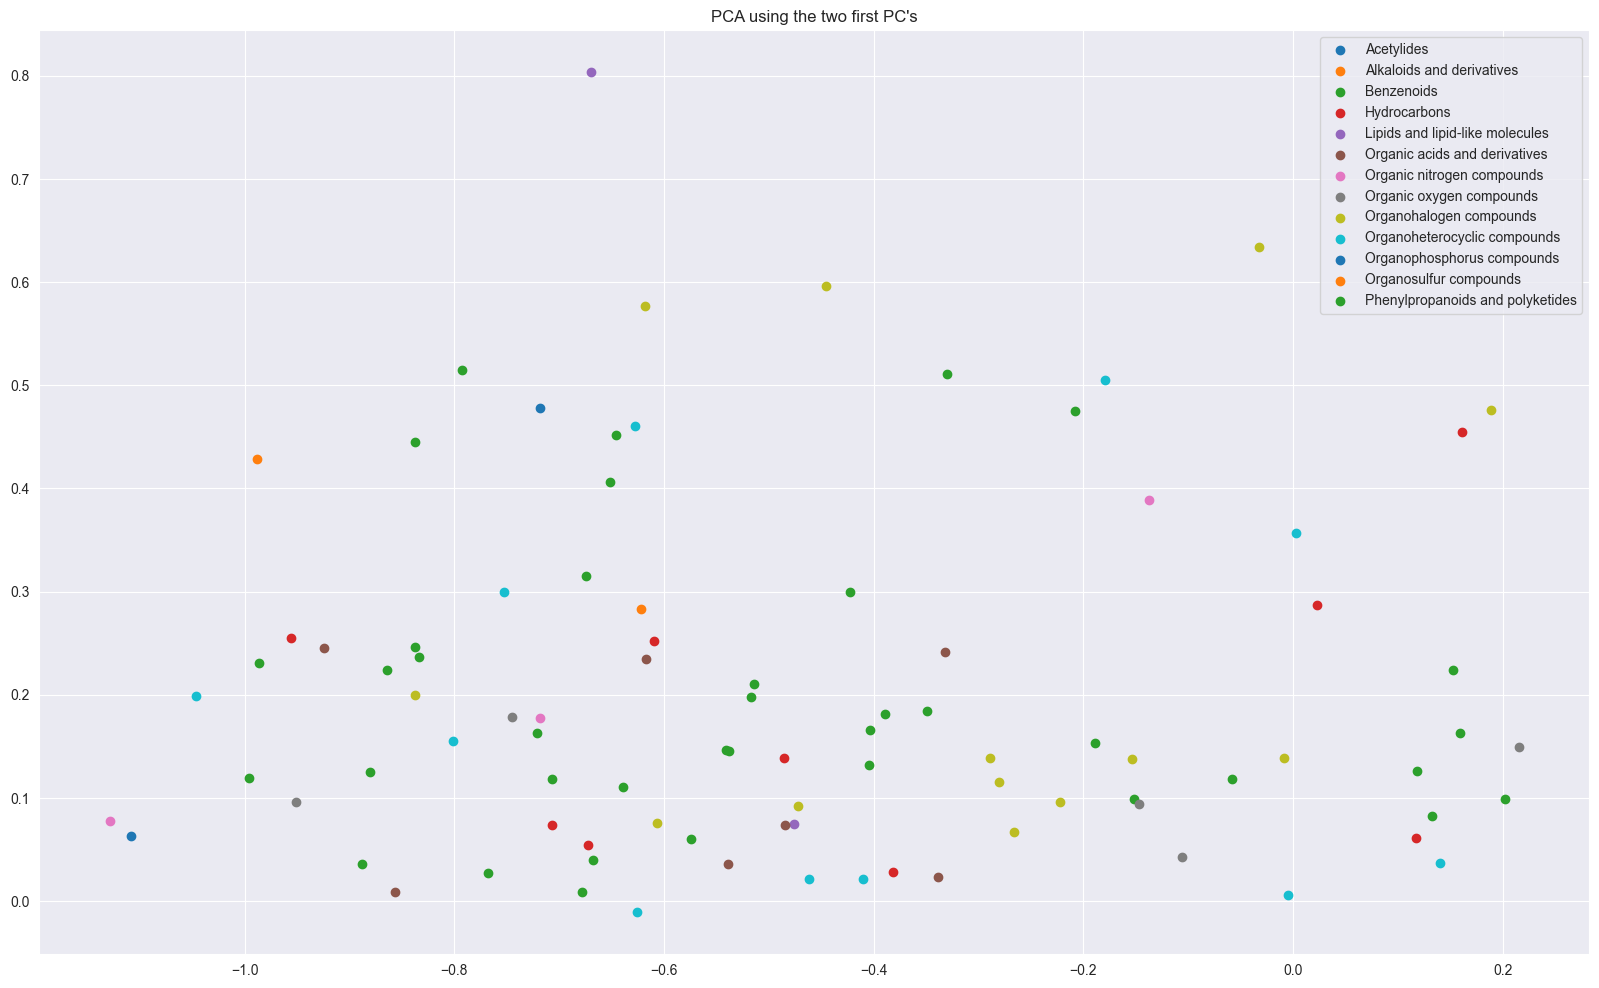

In [154]:
from grape.plots import pca_2d_plot
pca_2d_plot(latents=lats[rel_ids], labels=labels, save_fig=True, fig_size=(20,12))

### t-SNE

Alternatively, we could use the t-SNE (t-distributed Stochastic Neighbor Embedding) algorithm by [4] to perform dimensionality reduction. The algorithm essentially uses probabilistic similarity measures to cluster the input point for n-components (here 2) and relies on two hyperparameters: perplexity (approximately equal to the number of neighbors per point) and the number of iterations the algorithm runs for.

It is generally a tricky feat to have the algorithm converge and produce interesting results, but it is possible! Here is an example use:

<Axes: title={'center': 't-distributed Stochastic Neighbor Embedding'}>

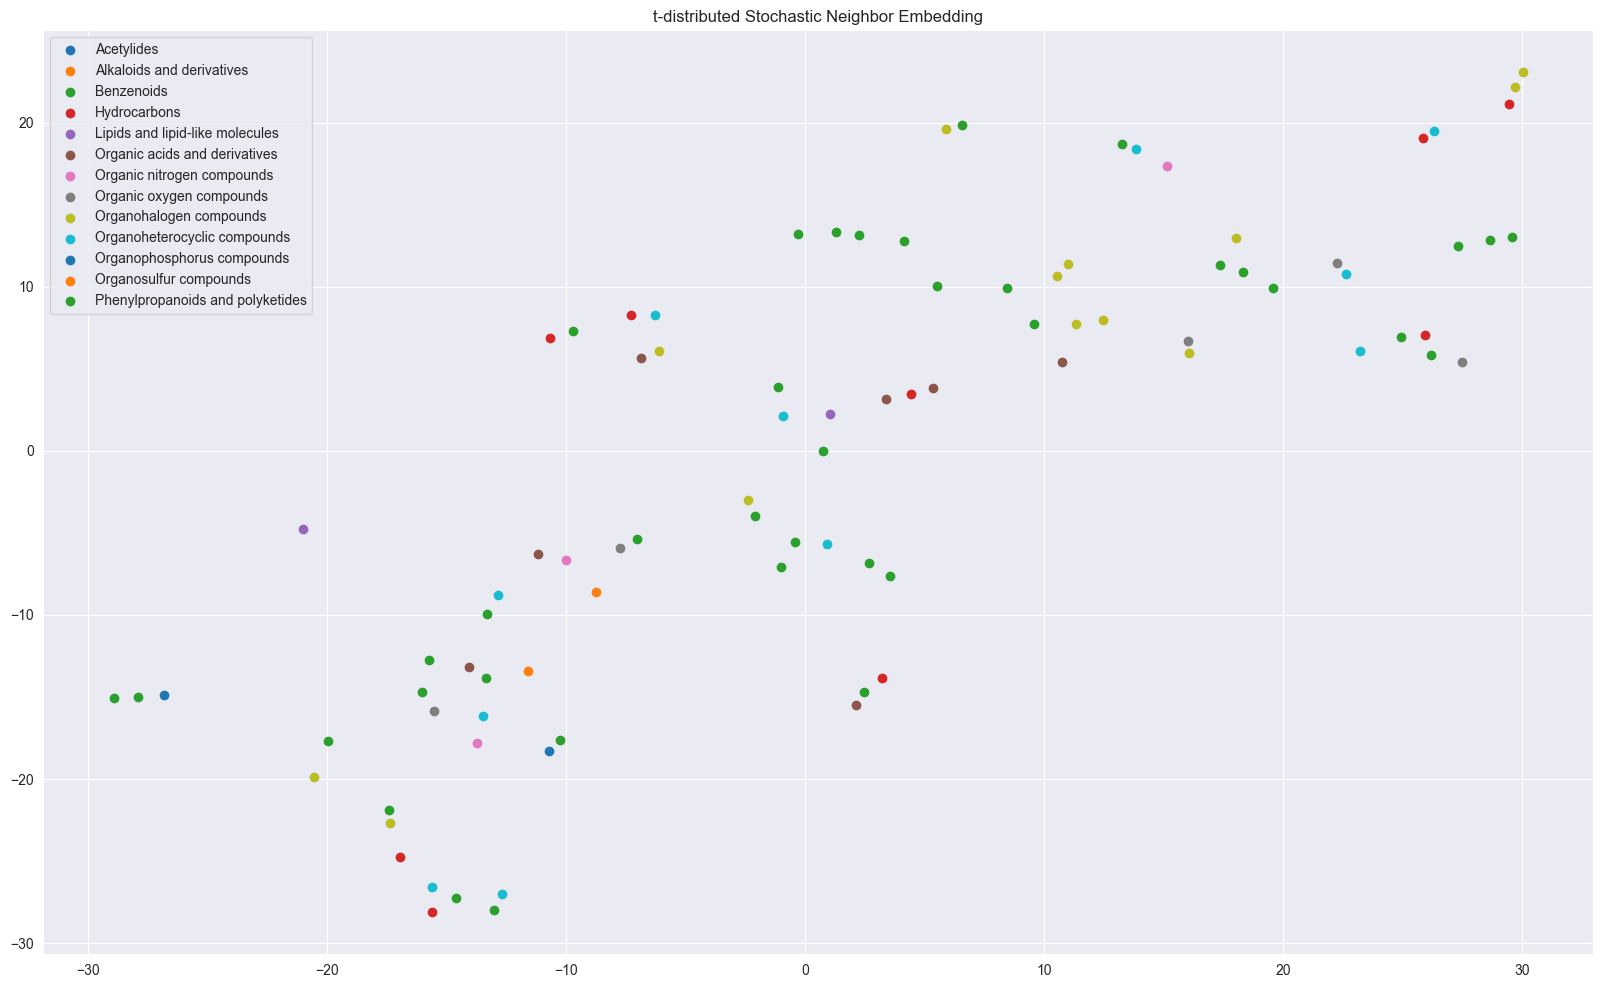

In [155]:
from grape.plots import tSNE_plot
tSNE_plot(latents=lats[rel_ids], labels=labels, perplexity=5, save_fig=True, fig_size=(20,12))

# Prediction

The final step of the typical machine learning pipeline is to use the model for **prediction**. This is made easy by the ``DataSet`` method ``predict_smiles``. The requirement for the method to work is that (1) the model and dataset share the same node- and edge-features (generally true if the model was trained using a specific ``DataSet`` object's data); and (2) that the input SMILES are valid compounds and recognized by ``rdkit``.

Using it looks like the following:

In [156]:
SMILES_to_predict = ['CC','CCO', 'CCCCCC']
data.predict_smiles(SMILES_to_predict, model) # The results are in degrees Celsius

{'CC': -231.94122314453125,
 'CCO': -82.51464080810547,
 'CCCCCC': -109.67493438720703}

Note that the results can only be rescaled if ``DataSet`` has internal `mean` and `std` value, or they have to be passed manually.

For completion, here is what it looks like to predict from a dataset *without* first training the model (using the FreeSolv dataset and AFP as an example):

In [157]:
from grape.datasets import FreeSolv
from grape.models import AFP

data = FreeSolv()
model = AFP(node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)
data.predict_smiles(['CC', 'CCCCCCCCC'], model)

{'CC': -0.06332151591777802, 'CCCCCCCCC': -0.06071934476494789}

These numbers are just random, of course.

-----

**References**

[1] Jean-Claude Bradley and Andrew Lang and Antony Williams, Jean-Claude Bradley Double Plus Good (Highly Curated
 and Validated) Melting Point Dataset, 2014, http://dx.doi.org/10.6084/m9.figshare.1031637

[2] Feunang, Y., Eisner, R., Knox, C., Chepelev, L., Hastings, J., Owen, G., Fahy, E., Steinbeck, C., Subramanian, S., Bolton, E., Greiner, R., & Wishart, D. S. (2016). ClassyFire: automated chemical classification with a comprehensive, computable taxonomy. Journal of Cheminformatics, 8(1), 61. https://doi.org/10.1186/s13321-016-0174-y

[3] Butina, D. (1999). Unsupervised Data Base Clustering Based on Daylight's Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381

[4] van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-sne. Journal of Machine
 Learning Research, 9 (86), 2579–2605. http://jmlr.org/papers/v9/vandermaaten08a.html

In [1]:
!export PATH=/Library/TeX/texbin:$PATH
!jupyter nbconvert 'GraPE Demonstration.ipynb' --to pdf --no-prompt

[NbConvertApp] Converting notebook GraPE Demonstration.ipynb to pdf
[NbConvertApp] Support files will be in GraPE Demonstration_files/
[NbConvertApp] Making directory ./GraPE Demonstration_files
[NbConvertApp] Writing 79472 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 678937 bytes to GraPE Demonstration.pdf
